# Convolutional Neural Networks: Step by Step

Welcome to Course 4's first assignment! In this assignment, you will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and (optionally) backward propagation. 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

We assume that you are already familiar with `numpy` and/or have completed the previous courses of the specialization. Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
This notebook will ask you to implement these functions from scratch in `numpy`. In the next notebook, you will use the TensorFlow equivalents of these functions to build the following model:

<img src="images/model.png" style="width:800px;height:300px;">

**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

## 3 - Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

<img src="images/conv_nn.png" style="width:350px;height:200px;">

In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

**Exercise**: Implement the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```

In [116]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)),  'constant', constant_values=(0, 0))
    ### END CODE HERE ###
    
    return X_pad

x =  [[[ 0.90337952  0.57367949  0.00287033]
  [ 0.61714491  0.3266449   0.5270581 ]
  [ 0.8859421   0.35726976  0.90853515]
  ..., 
  [ 0.54954792  0.92618143  0.91873344]
  [ 0.39487561  0.96326253  0.17395567]
  [ 0.12632952  0.13507916  0.50566217]]

 [[ 0.02152481  0.94797021  0.82711547]
  [ 0.01501898  0.17619626  0.33206357]
  [ 0.13099684  0.80949069  0.34473665]
  ..., 
  [ 0.62180623  0.54401012  0.65413735]
  [ 0.14454554  0.75152782  0.22204914]
  [ 0.51935182  0.78529603  0.02233043]]

 [[ 0.32436246  0.87292238  0.84470961]
  [ 0.53844059  0.86660827  0.94980599]
  [ 0.826407    0.85411544  0.0987434 ]
  ..., 
  [ 0.91527432  0.14555823  0.15773007]
  [ 0.18763167  0.6224959   0.9058095 ]
  [ 0.98995518  0.71112246  0.73180041]]

 ..., 
 [[ 0.89397767  0.6444108   0.09454426]
  [ 0.55137499  0.12897432  0.11882084]
  [ 0.2655489   0.7629083   0.69822095]
  ..., 
  [ 0.56413933  0.15457556  0.74217253]
  [ 0.36009269  0.60467402  0.00649297]
  [ 0.59051537  0.73342601  0.

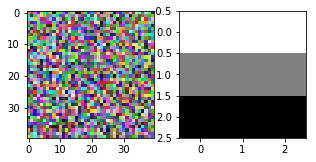

In [117]:
x = np.random.random([40,40,3])
print("x = ", x)
print("x.shape = ", x.shape)
f = np.matrix('1,1,1;0,0,0;-1,-1,-1')
x_pad = np.pad(x, ((2,2),(2,2),(2,2)), 'constant', constant_values = (0,0))
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x, cmap='gray', interpolation='nearest')
axarr[1].imshow(f, cmap='gray', interpolation='nearest')



x =  [[[[ 1.62434536 -0.61175641]
   [-0.52817175 -1.07296862]
   [ 0.86540763 -2.3015387 ]]

  [[ 1.74481176 -0.7612069 ]
   [ 0.3190391  -0.24937038]
   [ 1.46210794 -2.06014071]]

  [[-0.3224172  -0.38405435]
   [ 1.13376944 -1.09989127]
   [-0.17242821 -0.87785842]]]


 [[[ 0.04221375  0.58281521]
   [-1.10061918  1.14472371]
   [ 0.90159072  0.50249434]]

  [[ 0.90085595 -0.68372786]
   [-0.12289023 -0.93576943]
   [-0.26788808  0.53035547]]

  [[-0.69166075 -0.39675353]
   [-0.6871727  -0.84520564]
   [-0.67124613 -0.0126646 ]]]


 [[[-1.11731035  0.2344157 ]
   [ 1.65980218  0.74204416]
   [-0.19183555 -0.88762896]]

  [[-0.74715829  1.6924546 ]
   [ 0.05080775 -0.63699565]
   [ 0.19091548  2.10025514]]

  [[ 0.12015895  0.61720311]
   [ 0.30017032 -0.35224985]
   [-1.1425182  -0.34934272]]]


 [[[-0.20889423  0.58662319]
   [ 0.83898341  0.93110208]
   [ 0.28558733  0.88514116]]

  [[-0.75439794  1.25286816]
   [ 0.51292982 -0.29809284]
   [ 0.48851815 -0.07557171]]

  [[ 1.131

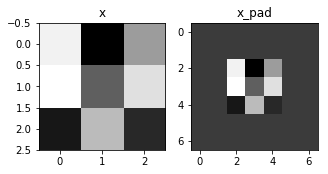

In [118]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
print("x = ", x)
print ("x[0] =", x[0])
x_pad = zero_pad(x, 2)

print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

**Expected Output**:

<table>
    <tr>
        <td>
            **x.shape**:
        </td>
        <td>
           (4, 3, 3, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x_pad.shape**:
        </td>
        <td>
           (4, 7, 7, 2)
        </td>
    </tr>
        <tr>
        <td>
            **x[1,1]**:
        </td>
        <td>
           [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
        </td>
    </tr>
        <tr>
        <td>
            **x_pad[1,1]**:
        </td>
        <td>
           [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
        </td>
    </tr>

</table>

### 3.2 - Single step of convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, you will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

**Exercise**: Implement conv_single_step(). [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).


In [ ]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = None
    # Sum over all entries of the volume s.
    Z = None
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = None
    ### END CODE HERE ###

    return Z

In [ ]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

**Expected Output**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

### 3.3 - Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**Exercise**: Implement the function below to convolve the filters W on an input activation A_prev. This function takes as input A_prev, the activations output by the previous layer (for a batch of m inputs), F filters/weights denoted by W, and a bias vector denoted by b, where each filter has its own (single) bias. Finally you also have access to the hyperparameters dictionary which contains the stride and the padding. 

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.
2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find how each of the corner can be defined using h, w, f and s in the code below.

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)** <br> This figure shows only a single channel.  </center></caption>


**Reminder**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

For this exercise, we won't worry about vectorization, and will just implement everything with for-loops.

In [ ]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = None
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = None
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = None
    pad = None
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = None
    n_W = None
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = None
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = None
    
    for i in range(None):                               # loop over the batch of training examples
        a_prev_pad = None                               # Select ith training example's padded activation
        for h in range(None):                           # loop over vertical axis of the output volume
            for w in range(None):                       # loop over horizontal axis of the output volume
                for c in range(None):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = None
                    vert_end = None
                    horiz_start = None
                    horiz_end = None
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = None
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = None
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

**Expected Output**:

<table>
    <tr>
        <td>
            **Z's mean**
        </td>
        <td>
            0.0489952035289
        </td>
    </tr>
    <tr>
        <td>
            **Z[3,2,1]**
        </td>
        <td>
            [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
        </td>
    </tr>
    <tr>
        <td>
            **cache_conv[0][1][2][3]**
        </td>
        <td>
            [-0.20075807  0.18656139  0.41005165]
        </td>
    </tr>

</table>


Finally, CONV layer should also contain an activation, in which case we would add the following line of code:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

You don't need to do it here. 


## 4 - Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the fxf window you would compute a max or average over. 

### 4.1 - Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function. 

**Exercise**: Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [1]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(None):                         # loop over the training examples
        for h in range(None):                     # loop on the vertical axis of the output volume
            for w in range(None):                 # loop on the horizontal axis of the output volume
                for c in range (None):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = None
                    vert_end = None
                    horiz_start = None
                    horiz_end = None
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = None
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = None
                    elif mode == "average":
                        A[i, h, w, c] = None
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

**Expected Output:**
<table>

    <tr>
    <td>
    A  =
    </td>
        <td>
         [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]

        </td>
    </tr>
    <tr>
    <td>
    A  =
    </td>
        <td>
         [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]

        </td>
    </tr>

</table>


Congratulations! You have now implemented the forward passes of all the layers of a convolutional network. 

The remainer of this notebook is optional, and will not be graded.


## 5 - Backpropagation in convolutional neural networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. If you wish however, you can work through this optional portion of the notebook to get a sense of what backprop in a convolutional network looks like. 

When in an earlier course you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in convolutional neural networks you can to calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are not trivial and we did not derive them in lecture, but we briefly presented them below.

### 5.1 - Convolutional layer backward pass 

Let's start by implementing the backward pass for a CONV layer. 

#### 5.1.1 - Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the acitivation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

**Exercise**: Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [ ]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = None
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = None
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = None
    
    # Retrieve information from "hparameters"
    stride = None
    pad = None
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = None
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = None                           
    dW = None
    db = None

    # Pad A_prev and dA_prev
    A_prev_pad = None
    dA_prev_pad = None
    
    for i in range(None):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = None
        da_prev_pad = None
        
        for h in range(None):                   # loop over vertical axis of the output volume
            for w in range(None):               # loop over horizontal axis of the output volume
                for c in range(None):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = None
                    vert_end = None
                    horiz_start = None
                    horiz_end = None
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = None

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += None
                    dW[:,:,:,c] += None
                    db[:,:,:,c] += None
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = None
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [ ]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

** Expected Output: **
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


## 5.2 Pooling layer - backward pass

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

### 5.2.1 Max pooling - backward pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling will be similar to this but using a different mask.  

**Exercise**: Implement `create_mask_from_window()`. This function will be helpful for pooling backward. 
Hints:
- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.

In [ ]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = None
    ### END CODE HERE ###
    
    return mask

In [ ]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
**mask =**
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Why do we keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

### 5.2.2 - Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

**Exercise**: Implement the function below to equally distribute a value dz through a matrix of dimension shape. [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [ ]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = None
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = None
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = None
    ### END CODE HERE ###
    
    return a

In [ ]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

### 5.2.3 Putting it together: Pooling backward 

You now have everything you need to compute backward propagation on a pooling layer.

**Exercise**: Implement the `pool_backward` function in both modes (`"max"` and `"average"`). You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an `if/elif` statement to see if the mode is equal to `'max'` or `'average'`. If it is equal to 'average' you should use the `distribute_value()` function you implemented above to create a matrix of the same shape as `a_slice`. Otherwise, the mode is equal to '`max`', and you will create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dZ.

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = None
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = None
    f = None
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = None
    m, n_H, n_W, n_C = None
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = None
    
    for i in range(None):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = None
        
        for h in range(None):                   # loop on the vertical axis
            for w in range(None):               # loop on the horizontal axis
                for c in range(None):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = None
                    vert_end = None
                    horiz_start = None
                    horiz_end = None
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = None
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = None
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += None
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = None
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = None
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += None
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

### Congratulations !

Congratulation on completing this assignment. You now understand how convolutional neural networks work. You have implemented all the building blocks of a neural network. In the next assignment you will implement a ConvNet using TensorFlow.